In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import json
import random
import pickle

# Import created data pipelines
from nlp_pipelines import *
pipelines = [
    nltk_stemmer, nltk_no_POS_lemmatizer, nltk_POS_lemmatizer
]
pipeline_names = [
    "nltk_stemmer", "nltk_no_POS_lemmatizer", "nltk_POS_lemmatizer"
]

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Necessary downloads
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

## Data Preprocessing

In [ ]:
# Preprocessing intents data
intents = json.loads(open('intents.json').read())

results = [[] for _ in range(len(pipelines))] # list of pipeline results for comparing pipelines
words = []  # all possible words in intents vocabulary
classes = []  # tags
docs = []  # pairs of tokenized word patterns and corresponding classes

for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Remove punctuation
        pattern = pattern.replace('?', '').replace('!', '').replace(',', '').replace('.', '')
        tokens = nltk.word_tokenize(pattern)
        words.extend([token for token in tokens if token not in "?!,."])
        docs.append((tokens, intent['tag']))

        # Apply pipelines to pattern and save results for comparison
        for i in range(len(pipelines)):
            results[i].extend(pipelines[i](pattern))
        
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# Sort tag names list
classes = sorted(classes)

We now evaluate the pipelines by comparing the pipeline results to the unprocessed list of tokens.

In [ ]:
for i, result in enumerate(results):
    print(f"***{pipeline_names[i]}***")
    # Print which words were modified
    for j, word in enumerate(words):
        if word.lower() != result[j].lower():
            print(f"{word} => {result[j].lower()}", end=' | ')
    print("\n")
    print("~"*25)

***nltk_stemmer***
there => ther | Whats => what | resume => resum | this => thi | Resume => resum | this => thi | this => thi | made => mad | does => doe | this => thi | Give => giv | summary => sum | Ilia => il | Briefly => brief | tell => tel | little => littl | Give => giv | Ilia => il | experiences => expery | qualifications => qual | Quickly => quick | describe => describ | Ilia => il | Ilia => il | Tell => tel | Ilia => il | Ilia => il | Detailed => detail | Ilia => il | software => softw | developer => develop | engineer => engin | tell => tel | Ilia => il | Give => giv | detailed => detail | description => describ | Ilia => il | Tell => tel | does => doe | Ilia => il | skills => skil | does => doe | Ilia => il | have => hav | does => doe | your => yo | like => lik | Ilia => il | programming => program | skills => skil | tools => tool | languages => langu | tools => tool | languages => langu | does => doe | Ilia => il | tools => tool | technologies => technolog | Ilia => il | c

The nltk_POS_lemmatizer pipeline produces the most desirable results and will thus be used for preprocessing the chatbot model input data from hereon.

In [ ]:
# Change words list to preprocessed result of nltk_POS_lemmatizer
words = results[pipeline_names.index('nltk_POS_lemmatizer')]

# Sort and remove duplicate words
words = sorted(list(set(words)))

In [ ]:
# Prepare training dataset
training_data = []
output_empty = [0] * len(classes)

for doc in docs:
    bag = []
    
    # Apply chosen pipeline to word_pattern in doc
    word_pattern = pipelines[pipeline_names.index('nltk_POS_lemmatizer')](' '.join(doc[0]))
    
    # Populate the bag using one-hot encoding method
    for word in words:
        bag.append(1) if word in word_pattern else bag.append(0)
    
    # Indicate which class the word_pattern belongs to
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    # Add (bag, tag) pair to total training set
    training_data.append([bag, output_row])

In [ ]:
random.shuffle(training_data)
training_data = np.array(training_data, dtype=object)

train_x = list(training_data[:, 0])
train_y = list(training_data[:, 1])

print(train_x[0])
print(train_y[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## Model Creation and Training

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])

In [ ]:
# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Implement early stopping to prevent overfitting and reduce training time
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='accuracy',
    min_delta=0.001,
    patience=35,
    verbose=1
)

In [ ]:
history = model.fit(
    train_x, train_y,
    epochs=150,
    batch_size=20,
    callbacks=[early_stopping]
)

Epoch 1/150
8/8 [==============================] - 0s 1ms/step - loss: 2.5797 - accuracy: 0.0508
Epoch 2/150
8/8 [==============================] - 0s 1ms/step - loss: 2.5316 - accuracy: 0.1441
Epoch 3/150
8/8 [==============================] - 0s 1ms/step - loss: 2.4549 - accuracy: 0.2119
Epoch 4/150
8/8 [==============================] - 0s 1ms/step - loss: 2.4037 - accuracy: 0.2458
Epoch 5/150
8/8 [==============================] - 0s 1ms/step - loss: 2.3601 - accuracy: 0.1949
Epoch 6/150
8/8 [==============================] - 0s 1ms/step - loss: 2.2823 - accuracy: 0.2373
Epoch 7/150
8/8 [==============================] - 0s 1ms/step - loss: 2.2393 - accuracy: 0.2034
Epoch 8/150
8/8 [==============================] - 0s 1ms/step - loss: 2.1609 - accuracy: 0.2627
Epoch 9/150
8/8 [==============================] - 0s 1ms/step - loss: 2.0767 - accuracy: 0.3220
Epoch 10/150
8/8 [==============================] - 0s 1ms/step - loss: 2.0467 - accuracy: 0.2797
Epoch 11/150
8/8 [===========

<AxesSubplot:>

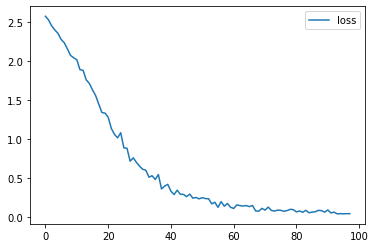

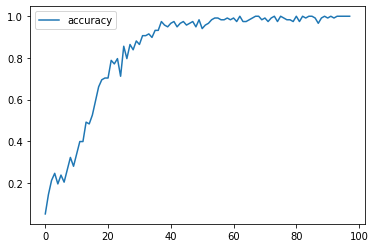

In [ ]:
# Plotting history (not too useful since there is no validation data)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot()
history_df.loc[:, ['accuracy']].plot()

In [ ]:
import os

# Save the model
model_path = './keras_DNN_model'
if not os.path.isdir(model_path):
    os.mkdir(model_path)
tf.keras.models.save_model(model, model_path)  # tf takes up too much space to import when uploading to web app

# Store words and classes in pickle file for use in baggin and classification
pickle.dump(words, open(f'{model_path}/words.pkl', 'wb'))
pickle.dump(classes, open(f'{model_path}/classes.pkl', 'wb'))

TypeError: can't pickle weakref objects

## Previous model training graphs

<AxesSubplot:>

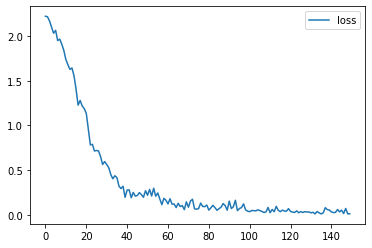

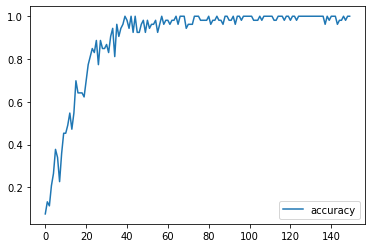

In [12]:
# SGD with momentum and nesterov optimizer, No early_stopping (May be overfitting)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot()
history_df.loc[:, ['accuracy']].plot()

<AxesSubplot:>

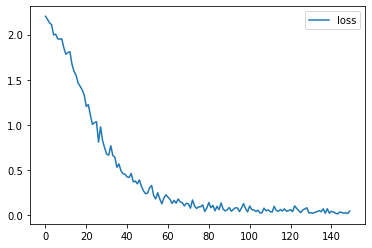

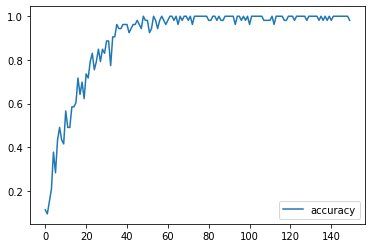

In [12]:
# Adam optimizer, No early_stopping (May be overfitting)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot()
history_df.loc[:, ['accuracy']].plot()

<AxesSubplot:>

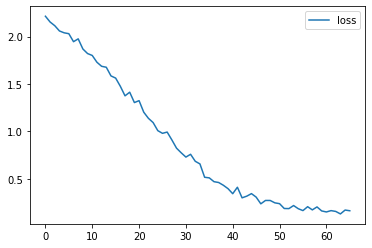

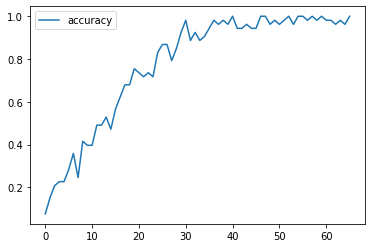

In [12]:
# Adam optimizer, With early_stopping, patience=25 (May be underfitting)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot()
history_df.loc[:, ['accuracy']].plot()